In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [3]:

import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-05 00:18:21,261 INFO: Initializing external client
2025-03-05 00:18:21,262 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 00:18:21,887 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215651


In [4]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1215651/featurestores/1203282/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [5]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (21.91s) rom Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Readin

In [6]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [7]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2023-01-01 00:00:00+00:00,2,0
1,2023-01-01 01:00:00+00:00,2,0
2,2023-01-01 02:00:00+00:00,2,0
3,2023-01-01 03:00:00+00:00,2,0
4,2023-01-01 04:00:00+00:00,2,0


In [8]:
ts_data["pickup_hour"].min()

'2023-01-01 00:00:00+00:00'

In [9]:
ts_data["pickup_hour"].max()

'2025-03-05 05:00:00+00:00'

In [10]:
ts_data_copy = ts_data.copy()

In [11]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [12]:
ts_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465097 entries, 0 to 2465096
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  int32              
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 37.6 MB


In [13]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [14]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465097 entries, 0 to 2465096
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 37.6 MB


In [15]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [16]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01
...,...,...,...,...
2465092,2025-03-05 01:00:00,263,10,2025-03
2465093,2025-03-05 02:00:00,263,5,2025-03
2465094,2025-03-05 03:00:00,263,3,2025-03
2465095,2025-03-05 04:00:00,263,4,2025-03


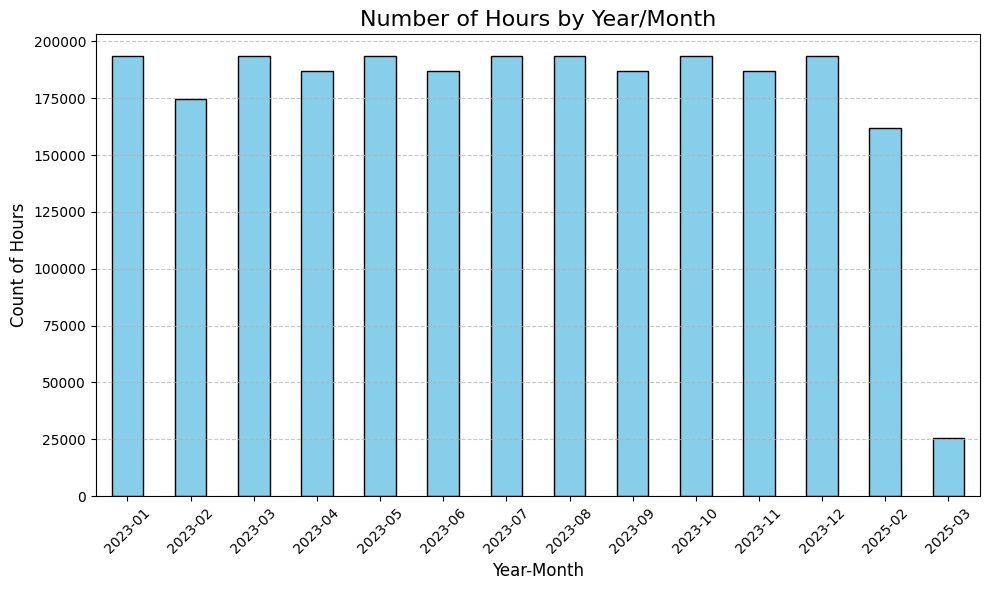

In [17]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [18]:
ts_data.head()

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01


In [19]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [20]:
filtered_data.drop(columns=["year_month"], inplace=True)

In [21]:
filtered_data.shape

(2277600, 3)

In [22]:
ts_data = filtered_data

In [23]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277600 entries, 0 to 2277599
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 34.8 MB


In [24]:
ts_data.head()["pickup_hour"].values

array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', '2023-01-01T03:00:00.000000000',
       '2023-01-01T04:00:00.000000000'], dtype='datetime64[ns]')

In [25]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)


In [26]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91515,110,115,101,125,129,137,109,137,132,89,...,8,38,37,68,74,98,85,89,2023-12-27 13:00:00,263
91516,104,109,89,133,130,143,165,103,106,111,...,8,14,30,34,49,76,96,88,2023-12-28 12:00:00,263
91517,100,114,110,117,134,130,188,250,173,142,...,9,8,11,38,46,55,73,73,2023-12-29 11:00:00,263
91518,151,148,147,134,119,137,124,126,160,205,...,36,13,14,16,20,25,42,54,2023-12-30 10:00:00,263


In [27]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-27 13:00:00,2
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-28 12:00:00,2
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-29 11:00:00,2
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-30 10:00:00,2


In [28]:
features_copy = features.copy()

In [29]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(91520, 675)

In [30]:
from datetime import datetime, timedelta
import pandas as pd
from src.data_utils import split_time_series_data

# Define the cutoff date as 28 days before today
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-05 00:24:33.813868')

In [31]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(91520, 674)
(91520,)
(0, 674)
(0,)


In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91520 entries, 0 to 91519
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 470.3 MB


In [33]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [34]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171646
[LightGBM] [Info] Number of data points in the train set: 91520, number of used features: 675
[LightGBM] [Info] Start training from score 16.630299


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x3275f03a0>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [35]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [36]:
predictions

array([ 0.16632143,  0.16632143,  0.16632143, ..., 83.42269769,
       75.76323756, 60.66289631])

In [37]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

1.9355


In [38]:
import joblib


# Save the pipeline
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['/Users/harshithharsha/MY DOCS/APL-AT-S/sp25_taxi-main/models/lgb_model.pkl']

In [39]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [40]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    #include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
model.save(str(config.MODELS_DIR) + "/lgb_model.pkl")
# model.save('C:\\Users\\mkhaw\\github\\sp25_taxi\\models\\lgb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/317883 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2049 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/48705 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1215651/models/taxi_demand_predictor_next_hour/3


Model(name: 'taxi_demand_predictor_next_hour', version: 3)

In [41]:
model

Model(name: 'taxi_demand_predictor_next_hour', version: 3)

In [42]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-03-05 00:28:41,256 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-05 00:28:41,259 INFO: Initializing external client
2025-03-05 00:28:41,259 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 00:28:41,870 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215651


In [43]:
from src.inference import get_model_predictions

In [44]:
preds = get_model_predictions(model, features_copy)

In [45]:
preds

,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0
...,...,...
91515,263,86.0
91516,263,95.0
91517,263,83.0
91518,263,76.0


In [46]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

1.8374
